# Model: Leading Hand

_Bastien Leduc - A20520860_\
_Paul Legout - A20522029_

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models, layers

import preprocessing
from resources import *

from sklearn.utils import shuffle

In [139]:
import importlib
import resources

importlib.reload(preprocessing)
importlib.reload(resources)

from resources import *

Some useful paths

In [2]:
DIR_DATA = "../../data"
DIR_ANNOTATIONS = DIR_DATA + "/annotations"
DIR_IMAGES = DIR_DATA + "/.data"

### Load data

In [19]:
# Load data, without bbox coordinates (just landmarks)
x, y, num_landmarks, labels = preprocessing.load_data_leading_hand(DIR_ANNOTATIONS, bbox=False)

In [20]:
x.shape

(97679, 2, 21, 2)

In [21]:
y.shape

(97679,)

In [23]:
# Total number of elements
dataset_size = len(x)
dataset_size

97679

In [24]:
x[0]

array([[[0.49253976, 0.6164478 ],
        [0.5075015 , 0.60568154],
        [0.51428396, 0.59451365],
        [0.51981753, 0.58536285],
        [0.5246562 , 0.57598394],
        [0.5018819 , 0.56990045],
        [0.50551075, 0.5513342 ],
        [0.50844836, 0.53738666],
        [0.51040715, 0.5263778 ],
        [0.4979835 , 0.5718403 ],
        [0.5186588 , 0.57074344],
        [0.5208185 , 0.58447397],
        [0.5176202 , 0.5925036 ],
        [0.4972705 , 0.57872075],
        [0.51737094, 0.5835499 ],
        [0.5164584 , 0.5959697 ],
        [0.51179135, 0.60170007],
        [0.4985609 , 0.58753085],
        [0.5138324 , 0.5936988 ],
        [0.51293314, 0.60267437],
        [0.50879943, 0.60653037]],

       [[0.60659814, 0.8935939 ],
        [0.5972008 , 0.90248305],
        [0.59255075, 0.9196457 ],
        [0.5900378 , 0.9348583 ],
        [0.5900358 , 0.9473183 ],
        [0.60183   , 0.9335918 ],
        [0.5940615 , 0.9522593 ],
        [0.58669835, 0.9605895 ],
        [0.5

In [25]:
num_labels = len(labels)

### Prepare and split data

Available labels

left_hand: 42812 (43.83%)
right_hand: 54867 (56.17%)


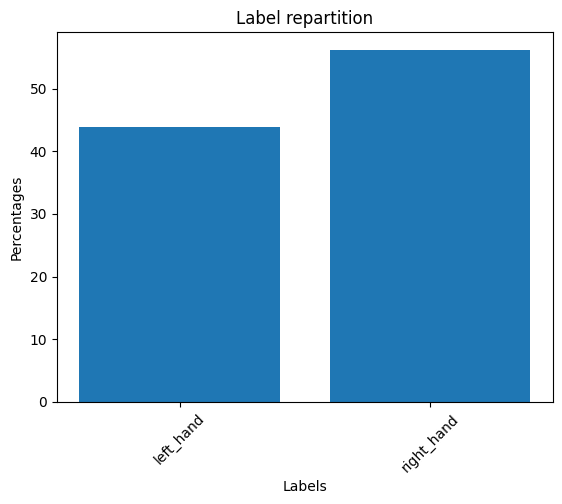

In [103]:
plot_label_repartition(pd.DataFrame(y), headers=["left_hand", "right_hand"])

70% training, 10% validation and 20% test

In [27]:
train_perc = 0.7
test_perc = 0.2
val_perc = 0.1


x, y = shuffle(x, y)

In [28]:

x_train = x[: int(train_perc * dataset_size)]
y_train = y[: int(train_perc * dataset_size)]

x_test = x[int(train_perc * dataset_size): int((train_perc + test_perc) * dataset_size) ]
y_test = y[int(train_perc * dataset_size): int((train_perc + test_perc) * dataset_size) ]

x_val = x[int((train_perc + test_perc) * dataset_size): ]
y_val = y[int((train_perc + test_perc) * dataset_size): ]

### Model

In [49]:
def create_model(shape):
	input_tensor = layers.Input(shape=shape)

	#################### Feature extraction ####################

	x = layers.Conv1D(filters=8, kernel_size=5, strides=1, padding="same")(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)

	x = layers.Conv1D(filters=16, kernel_size=5, strides=1, padding="same")(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)

	
	#################### Classification ####################	

	x = layers.Flatten()(x)
	output_tensor = layers.Dense(1, activation="sigmoid")(x)

	return models.Model(inputs=[input_tensor], outputs=[output_tensor])

In [50]:
model = create_model(shape=x[0].shape)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 21, 2)]        0         
                                                                 
 conv1d_10 (Conv1D)          (None, 2, 21, 8)          88        
                                                                 
 batch_normalization_10 (Bat  (None, 2, 21, 8)         32        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 2, 21, 8)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, 2, 21, 16)         656       
                                                                 
 batch_normalization_11 (Bat  (None, 2, 21, 16)        64        
 chNormalization)                                          

In [ ]:
hist = compile_and_fit(
    model,
    x_train,
    y_train,
    validation_data=(x_val, y_val),
	max_epochs=100,
    run_on_gpu=False,
    loss_function=tf.keras.losses.BinaryCrossentropy()
)

save_model(model, "model_leading_hand")

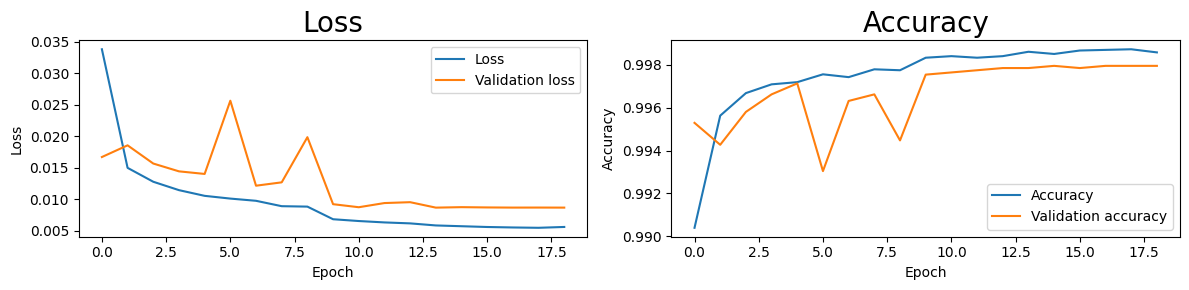

In [52]:
plot(hist)

In [140]:
predictions_summary("model_leading_hand", x_test, y_test, labels, run_on_gpu=False, short=True)

2023-04-10 21:28:22.248284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 21:28:23.613487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Loss: 0.00718275923281908
Accuracy: 99.857%

Min: 6.071876e-14
Mean: 0.562401
Max: 1.0


### Average time to make a prediction

In [141]:
import time
from random import randint

In [144]:
num_iters = 2000
count = 0

for i in range(num_iters):
	index = randint(0, x_test.shape[0] - 1)

	start = time.time()

	with tf.device('CPU'):
		model.predict(np.array([x_test[index]]), verbose=False)

	count += time.time() - start

print(f"Average time: {round(count / num_iters, 4)} seconds")

2023-04-10 21:30:01.665902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Average time: 0.023 seconds
